In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy.special import gamma

In [38]:
def norm_pdf(x, mean, scale):
    return 1 / (np.sqrt(2*np.pi)*scale) * np.exp(-0.5*(x-mean/scale)**2)
def compare_cdf_ecdf_norm(sizes):
    fig, axes = plt.subplots(1, 1, figsize=(8,8))
    axes.plot(np.linspace(-4, 4, 100), norm.cdf(np.linspace(-5, 5, 100)), label='True', color='red')

    res_dict = {}
    for size in sizes:
        X = norm.rvs(size=size)
        X_sorted = np.sort(X)
        X_emp_cdf = np.arange(len(X_sorted))/len(X_sorted)
        X_true_cdf = norm.cdf(X_sorted)

        axes.step(X_sorted, X_emp_cdf)

        # How close is the Empirical CDF to True CDF?
        # 0. error
        errors = (X_true_cdf - X_emp_cdf)**2
        errors_abs = np.abs(X_true_cdf - X_emp_cdf)
        # Errors spike at the shoulders. Why do errors around the mean are small? Why the errors at the tails are small?
        print("Error analysis, size=", size, "\n", 50*"=", "\n", 50*"=")
        # 1. MAE
        MAE = errors_abs.mean()
        print('MAE: ', MAE)
        # 2. MSE
        MSE = np.mean(errors)
        print("MSE: ", MSE)
        # Both MAE and MSE are small but those put equal weight on all observations.
        # How can we weight errors so that they appropriately represent all parts of the distribution?
        # 3. Kolmogorov-Smirnov statistic:
        KS_stat = (X_true_cdf-X_emp_cdf).max()
        print("Kolmogorov-Smirnov statistic: ", KS_stat)

        # 4. Cramer von Mises distance - density weighted error
        dx = np.diff(X_sorted)
        dx = np.append(dx, dx[-1])
        CM_distance = np.sum(
            (X_true_cdf-X_emp_cdf)**2*norm_pdf(X_sorted, 0, 1)*dx
        )
        print("CM_distance is: ", CM_distance)

        # 5. Anderson-Darling distance - puts more weights on tails

        AD_distance = np.sum(
            (X_true_cdf-X_emp_cdf)**2/np.clip((X_emp_cdf*(1-X_emp_cdf)), 1e-8, None)*norm_pdf(X_sorted, 0, 1)*dx
        )
        print("AD distance: ", AD_distance)
        # 6. Cramer von Mises distance with observation weighted summands
        X_sorted_tail = X_sorted[(np.percentile(X_sorted, 0.05) > X_sorted)| (X_sorted > np.quantile(X_sorted, 0.95))]
        X_true_cdf_tail = X_true_cdf[(np.percentile(X_true_cdf, 0.05) > X_true_cdf) | (X_true_cdf > np.quantile(X_true_cdf, 0.95))]
        X_emp_cdf_tail = X_emp_cdf[(np.percentile(X_emp_cdf, 0.05) > X_emp_cdf)| (X_emp_cdf> np.quantile(X_emp_cdf, 0.95))]
        tail_distance = np.abs(X_true_cdf_tail-X_emp_cdf_tail).mean()
        print(f"tail_distance (MAE )is: {tail_distance}")

        print("\n", 50 * "=")
        # Update res_dict
        res_dict[size] = [MAE, MSE, KS_stat, CM_distance, AD_distance, tail_distance]
    legend = ["true cdf"]
    for s in sizes:
        legend.append(s)
    plt.legend(legend)

    return axes, res_dict


Below we examine convergence of ecdf to cdf for standard normal distribution.

Error analysis, size= 14 
MAE:  0.04970064449720816
MSE:  0.0032174057906664082
Kolmogorov-Smirnov statistic:  0.06511433289989718
CM_distance is:  0.0046878293665868565
AD distance:  8989.997781873228
tail_distance (MAE )is: 0.04141849992722421

Error analysis, size= 21 
MAE:  0.05968947163538277
MSE:  0.004351114795273973
Kolmogorov-Smirnov statistic:  0.09679485373677366
CM_distance is:  0.004453753450808924
AD distance:  10160.241589684067
tail_distance (MAE )is: 0.04326229069179518

Error analysis, size= 60 
MAE:  0.048564063135819666
MSE:  0.0033725521718578075
Kolmogorov-Smirnov statistic:  0.11283070343223434
CM_distance is:  0.0029635532264016286
AD distance:  0.7480424644099862
tail_distance (MAE )is: 0.01377437239540212

Error analysis, size= 256 
MAE:  0.015280344399288524
MSE:  0.0003328172739197117
Kolmogorov-Smirnov statistic:  0.045140545453221215
CM_distance is:  0.0002997444476672848
AD distance:  3.874737960366586
tail_distance (MAE )is: 0.010925443964743403

Error a

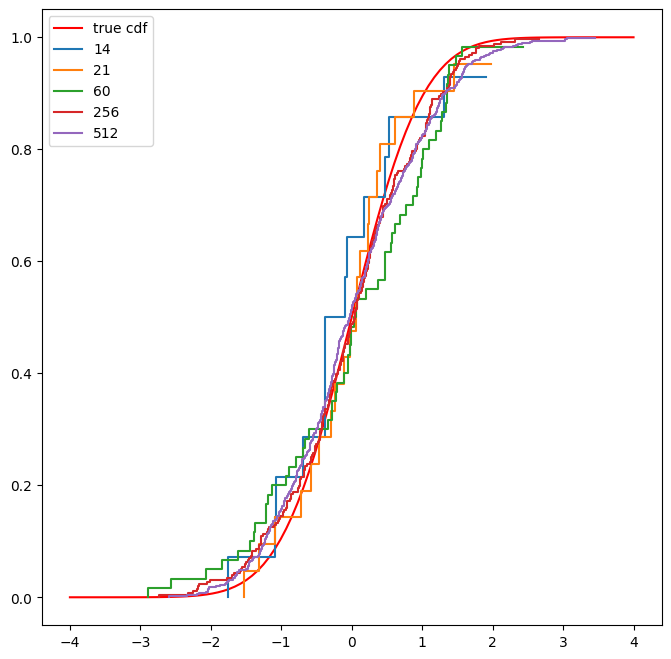

In [39]:
axes, results = compare_cdf_ecdf_norm([14, 21, 60, 256, 512])

Results suggest that convergence of empirical cdf to true cdf is not that fast. Even for sample size 512 the deviations remain significant. 
The plot also shows that the errors are the largest in the 'shoulder' areas of the distribution. However AD_distance statistic tells us also that differences in the tails are also large especially for small samples.

Below the same analysis for a distribution with heavier tails - t with df = 3

In [44]:
def t_pdf(x, df):
    return gamma(0.5*(df+1)) / (np.sqrt(np.pi * df) * gamma(df/2)) * (1 + x**2/df)**(-0.5*(df+1))

def compare_cdf_ecdf_t(sizes):
    fig, axes = plt.subplots(1, 1, figsize=(8,8))
    axes.plot(np.linspace(-4, 4, 100), t.cdf(np.linspace(-5, 5, 100), df=3), label='True', color='red')

    res_dict = {}
    for size in sizes:
        X = t.rvs(size=size, df=3)
        X_sorted = np.sort(X)
        X_emp_cdf = np.arange(len(X_sorted))/len(X_sorted)
        X_true_cdf = norm.cdf(X_sorted)

        axes.step(X_sorted, X_emp_cdf)

        # How close is the Empirical CDF to True CDF?
        # 0. error
        errors = (X_true_cdf - X_emp_cdf)**2
        errors_abs = np.abs(X_true_cdf - X_emp_cdf)
        # Errors spike at the shoulders. Why do errors around the mean are small? Why the errors at the tails are small?
        print("Error analysis, size=", size, "\n", 50*"=", "\n", 50*"=")
        # 1. MAE
        MAE = errors_abs.mean()
        print('MAE: ', MAE)
        # 2. MSE
        MSE = np.mean(errors)
        print("MSE: ", MSE)
        # Both MAE and MSE are small but those put equal weight on all observations.
        # How can we weight errors so that they appropriately represent all parts of the distribution?
        # 3. Kolmogorov-Smirnov statistic:
        KS_stat = (X_true_cdf-X_emp_cdf).max()
        print("Kolmogorov-Smirnov statistic: ", KS_stat)

        # 4. Cramer von Mises distance - density weighted error
        dx = np.diff(X_sorted)
        dx = np.append(dx, dx[-1])
        CM_distance = np.sum(
            (X_true_cdf-X_emp_cdf)**2*t_pdf(X_sorted, 3)*dx
        )
        print("CM_distance is: ", CM_distance)

        # 5. Anderson-Darling distance - puts more weights on tails

        AD_distance = np.sum(
            (X_true_cdf-X_emp_cdf)**2/np.clip((X_emp_cdf*(1-X_emp_cdf)), 1e-8, None)*t_pdf(X_sorted, 3)*dx
        )
        print("AD distance: ", AD_distance)
        # 6. Cramer von Mises distance with observation weighted summands
        X_sorted_tail = X_sorted[(np.percentile(X_sorted, 0.05) > X_sorted)| (X_sorted > np.quantile(X_sorted, 0.95))]
        X_true_cdf_tail = X_true_cdf[(np.percentile(X_true_cdf, 0.05) > X_true_cdf) | (X_true_cdf > np.quantile(X_true_cdf, 0.95))]
        X_emp_cdf_tail = X_emp_cdf[(np.percentile(X_emp_cdf, 0.05) > X_emp_cdf)| (X_emp_cdf> np.quantile(X_emp_cdf, 0.95))]
        tail_distance = np.abs(X_true_cdf_tail-X_emp_cdf_tail).mean()
        print(f"tail_distance (MAE )is: {tail_distance}")

        print("\n", 50 * "=")
        # Update res_dict
        res_dict[size] = [MAE, MSE, KS_stat, CM_distance, AD_distance, tail_distance]
    legend = ["true cdf"]
    for s in sizes:
        legend.append(s)
    plt.legend(legend)

    return axes, res_dict


Error analysis, size= 14 
MAE:  0.1789655535466686
MSE:  0.0475430250491643
Kolmogorov-Smirnov statistic:  0.14734340513692945
CM_distance is:  0.05242503788747996
AD distance:  0.5516226833056965
tail_distance (MAE )is: 0.0172515293734073

Error analysis, size= 21 
MAE:  0.10583885074183604
MSE:  0.014292145431255024
Kolmogorov-Smirnov statistic:  0.19747713483832863
CM_distance is:  0.01286674244387352
AD distance:  0.0676773333129836
tail_distance (MAE )is: 0.0238065788079597

Error analysis, size= 60 
MAE:  0.05451495498493445
MSE:  0.004014635810603168
Kolmogorov-Smirnov statistic:  0.13699272214312286
CM_distance is:  0.0028248000904392634
AD distance:  0.5062920290057203
tail_distance (MAE )is: 0.0232444405828839

Error analysis, size= 256 
MAE:  0.021288330405586628
MSE:  0.0007953400567593356
Kolmogorov-Smirnov statistic:  0.06644401069824846
CM_distance is:  0.0008183143825042686
AD distance:  0.009432088467709952
tail_distance (MAE )is: 0.023511180532682648

Error analysis, 

(-5.0, 5.0)

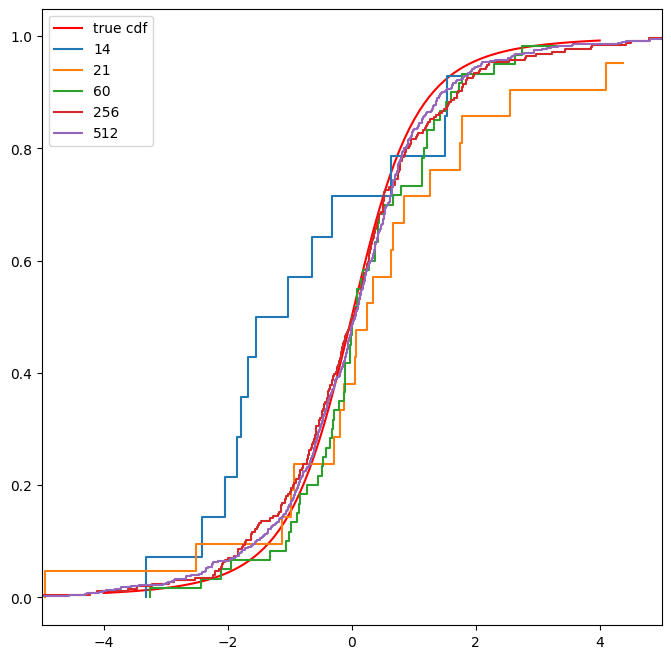

In [45]:
axes, results = compare_cdf_ecdf_t([14, 21, 60, 256, 512])
axes.set_xlim([-5, 5])

Similar interpretation as for normal distribution. 
It should be noted that all results are random and depend on the sample.